In [1]:
from google.colab import drive
drive.mount('/content/drive',)# force_remount=True)

Mounted at /content/drive


In [2]:
!nvidia-smi

Mon May 10 16:49:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import tensorflow as tf
import datetime as dt
import cv2
import numpy as np

# Using pretrained ResNet model to obtain Image embeddings

In [4]:
model_embedding = tf.keras.applications.DenseNet121(
    include_top=False, weights='imagenet', input_tensor=None, input_shape=(512,512,3),
    pooling=None,
)

def load_img(path):
  img = cv2.imread(path,cv2.IMREAD_UNCHANGED) 
  img = cv2.resize(img,(512,512),interpolation=cv2.INTER_AREA)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img = tf.image.convert_image_dtype(img,tf.float32)[tf.newaxis, ...] 
  return img 

def get_embeddings(path):
  img = load_img(path)
  op = model_embedding.predict(img,steps=1)
  op = tf.squeeze(op, axis=None, name=None)
  op = tf.reduce_mean(op, axis=(0,1), keepdims=False, name=None).numpy()
  op = op.tolist()
  return op

29089792/29084464 [==============================] - 0s 0us/step


In [5]:
# time taken to generate an embedding vector
image_path = '/content/drive/MyDrive/Myntra_fashion_recommendation/deepfashion_data/val_images/000001.jpg'
t = dt.datetime.now()
embedding_vector = get_embeddings(image_path)
print("Time taken to generate embeddings ",dt.datetime.now()-t)

Time taken to generate embeddings  0:00:36.011968


# Create and store embeddings

In [6]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
images_directory = '/content/drive/MyDrive/Myntra_fashion_recommendation/deepfashion_data/train2017'

images_list = []
images_path = []
image_embedding = []
json_object = {}

for root_dir, dirs, files in os.walk(images_directory):
  for image in files:
    image_path = root_dir + os.sep + image
    embedding = get_embeddings(image_path)
    
    image_embedding.append(embedding)
    images_path.append(image_path)
    # remove extension from image name
    images_list.append(int(float(image.split('.')[0])))
    # images_list.append(image.split('.')[0])

df = pd.DataFrame({ 'image_path':images_path,
                    'file_name':images_list,
                   'description_vector':image_embedding})

In [7]:
df.head()

,image_path,file_name,description_vector
0,/content/drive/MyDrive/Myntra_fashion_recommen...,6,"[0.0003704138216562569, 0.00218894612044096, 0..."
1,/content/drive/MyDrive/Myntra_fashion_recommen...,4,"[0.00035370164550840855, 0.0034901374019682407..."
2,/content/drive/MyDrive/Myntra_fashion_recommen...,11,"[0.00039369380101561546, 0.0015696953050792217..."
3,/content/drive/MyDrive/Myntra_fashion_recommen...,1,"[0.0002521714777685702, 0.0025043305940926075,..."
4,/content/drive/MyDrive/Myntra_fashion_recommen...,5,"[0.0005451269098557532, 0.0022076661698520184,..."


# Using Facebook's FAISS library for fast similarity search

In [8]:
!pip install faiss-gpu

     |████████████████████████████████| 89.4MB 57kB/s 


In [22]:
import faiss

# Step 1: Change data type
embeddings = np.array([embedding for embedding in image_embedding]).astype("float32")

# reference: https://github.com/facebookresearch/faiss/wiki/MetricType-and-distances#how-can-i-index-vectors-for-cosine-similarity
# Step 2: Instantiate the index
index = faiss.IndexFlatIP(embeddings.shape[1])
# normalize the vectors for cosine similarity
faiss.normalize_L2(x=embeddings)

# Step 3: Pass the index to IndexIDMap
index = faiss.IndexIDMap(index)

# Step 4: Add vectors and their IDs
index.add_with_ids(embeddings, np.arange(len(images_list)))

# Inference obtain similar images from our corpus

*****QUERY IMAGE*****


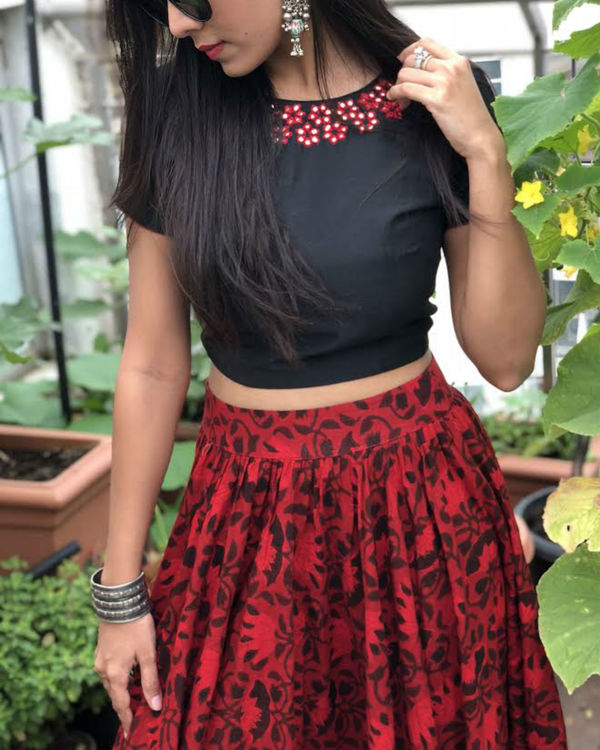

====SIMILAR IMAGES====
image id:67


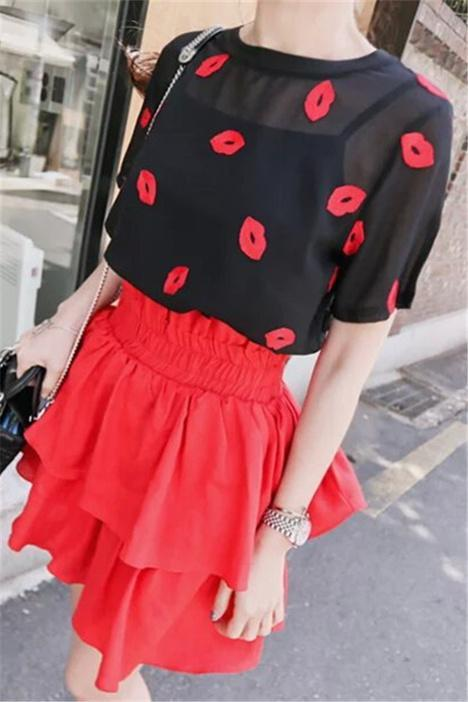

image id:37


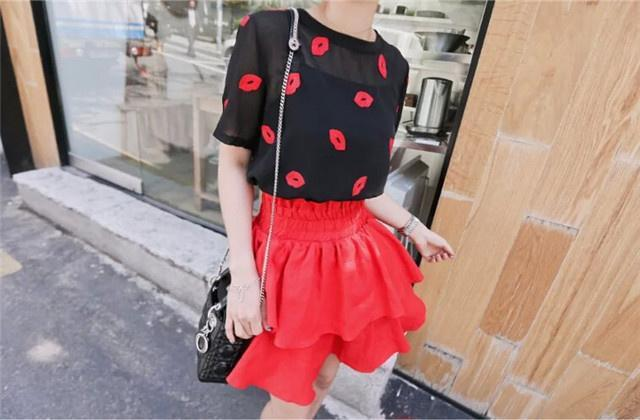

image id:76


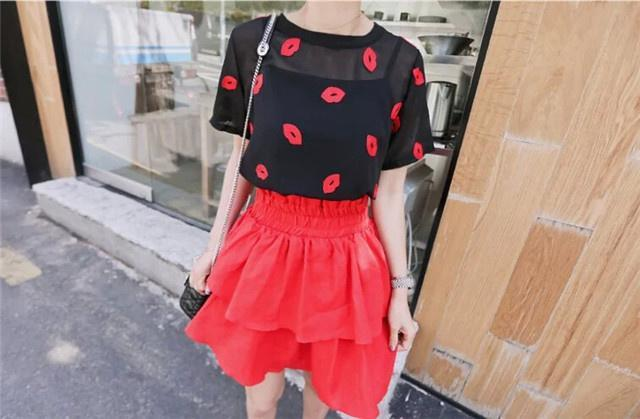

image id:21


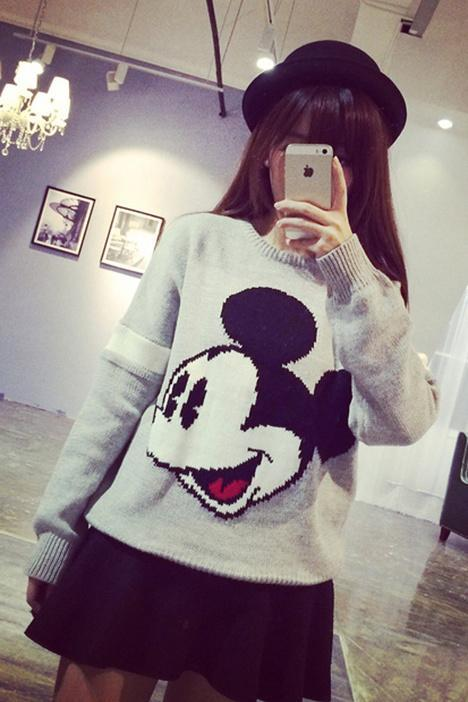

image id:6


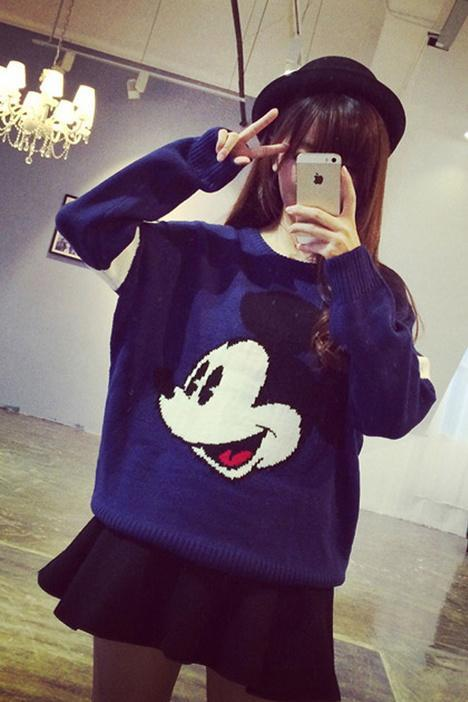

In [27]:
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

# test image
test_img = '/content/drive/MyDrive/Myntra_fashion_recommendation/deepfashion_data/women_dress.jpg'

# get embedding
query_vector = get_embeddings(test_img)
# find top 5 similar images
distances, indices = index.search(np.array([query_vector]).astype("float32"), k=5)

print('*****QUERY IMAGE*****')
cv2_imshow(cv2.imread(test_img))
print('====SIMILAR IMAGES====')
def plot_images(li):
   for i in range(len(li[0])): 
     print(f'image id:{li[0][i]}')
     outimage = cv2.imread(df['image_path'].iloc[li[0][i]])
     cv2_imshow(outimage)

# plot similar images
plot_images(indices)